In [1]:
import time

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(palette="bright")
import tqdm

import jax.numpy as np
from jax import random
from jax.config import config; config.update("jax_platform_name", "gpu")
from jax.scipy.special import logsumexp
from jax.tree_util import tree_map, tree_multimap

import numpyro.distributions as dist
from numpyro.handlers import sample
from numpyro.hmc_util import initialize_model
from numpyro.mcmc import hmc
from numpyro.util import fori_collect

In [2]:
num_categories = 3
num_words = 10
num_supervised_data = 100
num_unsupervised_data = 500
rng = random.PRNGKey(1)
rng, rng_transition, rng_emission = random.split(rng, 3)

transition_prior = np.ones(num_categories)
emission_prior = np.repeat(0.1, num_words)

transition_prob = dist.dirichlet.rvs(transition_prior, num_categories, random_state=rng_transition)
emission_prob = dist.dirichlet.rvs(emission_prior, num_categories, random_state=rng_emission)

In [3]:
# simulate data
start_prob = np.repeat(1. / num_categories, num_categories)
categories, words = [], []
for t in range(num_supervised_data + num_unsupervised_data):
    rng, rng_transition, rng_emission = random.split(rng, 3)
    if t == 0 or t == num_supervised_data:
        category = dist.categorical.rvs(start_prob, random_state=rng_transition)
    else:
        category = dist.categorical.rvs(transition_prob[category], random_state=rng_transition)
    word = dist.categorical.rvs(emission_prob[category], random_state=rng_emission)
    categories.append(category)
    words.append(word)
categories, words = np.stack(categories), np.stack(words)

# split into supervised data and unsupervised data
supervised_categories = categories[:num_supervised_data]
supervised_words = categories[:num_supervised_data]
unsupervised_words = categories[num_supervised_data:]

In [4]:
num_warmup_steps = num_samples = 150

### NumPyro

In [5]:
def forward_log_prob(prev_log_prob, curr_word, transition_log_prob, emission_log_prob):
    log_prob = np.expand_dims(prev_log_prob, axis=1) + transition_log_prob
    log_prob = log_prob + emission_log_prob[:, curr_word]
    return logsumexp(log_prob, axis=0)

def semi_supervised_hmm(supervised_categories, supervised_words, unsupervised_words):
    transition_prob = sample("transition_prob", dist.dirichlet(
        np.broadcast_to(transition_prior, (num_categories, num_categories))))
    emission_prob = sample("emission_prob", dist.dirichlet(
        np.broadcast_to(emission_prior, (num_categories, num_words))))

    sample("supervised_categories", dist.categorical(transition_prob[supervised_categories[:-1]]),
           obs=supervised_categories[1:])
    sample("supervised_words", dist.categorical(emission_prob[supervised_categories]),
           obs=supervised_words)

    transition_log_prob = np.log(transition_prob)
    emission_log_prob = np.log(emission_prob)
    log_prob = emission_log_prob[:, unsupervised_words[0]]
    # TODO: to be replaced by lax.scan when its jvp rule is implemented
    for t in range(1, len(unsupervised_words)):
        log_prob = forward_log_prob(log_prob, unsupervised_words[t],
                                    transition_log_prob, emission_log_prob)
    prob = np.clip(np.exp(logsumexp(log_prob, axis=0)), a_min=np.finfo(log_prob.dtype).tiny)
    return sample("forward_prob", dist.bernoulli(prob), obs=1)

In [6]:
init_params, potential_fn, transform_fn = initialize_model(
    random.PRNGKey(2), semi_supervised_hmm,
    (supervised_categories, supervised_words, unsupervised_words), {})
init_kernel, sample_kernel = hmc(potential_fn, algo="NUTS")

hmc_state, wa_state, warmup_update = init_kernel(init_params, num_warmup_steps, run_warmup=False)

In [7]:
start = time.time()
warmup_update(0, (hmc_state.update(step_size=10.), wa_state))
print("time to compile sample_kernel and wa_update:", time.time() - start)

time to compile sample_kernel and wa_update: 451.62206411361694


In [8]:
for t in tqdm.trange(num_warmup_steps):
    hmc_state, wa_state = warmup_update(t, (hmc_state, wa_state))

100%|██████████| 150/150 [27:43<00:00,  7.77s/it]


In [17]:
hmc_states = fori_collect(num_samples, sample_kernel, hmc_state,
                          transform=lambda state: {
                              "transition_prob": transform_fn(state.z)["transition_prob"],
                              "num_steps": state.num_steps},
                          use_prims=False)

100%|██████████| 150/150 [28:17<00:00, 15.86s/it]


In [18]:
print(hmc_states["num_steps"].copy())

[ 146  230  383   45   82   35   19  255 1023  127  482  360  306  332
   63   63  208 1023 1023    6  511   63  292  801    6 1023  767  212
  127  348 1023   41  383  639  895  639  383  255   63  127  341   51
 1023 1023  191  788  511  417  895 1023  511 1023  511  342   83 1023
 1023  107 1023   63  191  300  319  255  190  834  511  127 1023  383
  345   89  127  164  929  223  378   64  160  255  767 1023  767  127
    8  584   40  383 1023 1023 1023 1023  376  127 1023 1023  371 1023
 1023  127 1023 1023  383 1023  742  255 1023 1023  638 1023  184 1023
 1023  645  139 1023 1023  134  255 1023 1023  127  255 1023   63  295
 1023  277   50   49  152  319   78 1023 1023  305  821 1023  437 1023
   63 1023 1023  127 1023 1023 1023 1023 1023  340]


### Stan

In [13]:
import urllib

import pystan

url = "https://raw.githubusercontent.com/stan-dev/example-models/master/misc/hmm/hmm-semisup.stan"
stan_model = urllib.request.urlopen(url).read().decode("utf-8")
print(stan_model)

data {
  int<lower=1> K;  // num categories
  int<lower=1> V;  // num words
  int<lower=0> T;  // num supervised items
  int<lower=1> T_unsup;  // num unsupervised items
  int<lower=1,upper=V> w[T]; // words
  int<lower=1,upper=K> z[T]; // categories
  int<lower=1,upper=V> u[T_unsup]; // unsup words
  vector<lower=0>[K] alpha;  // transit prior
  vector<lower=0>[V] beta;   // emit prior
}
parameters {
  simplex[K] theta[K];  // transit probs
  simplex[V] phi[K];    // emit probs
}
model {
  for (k in 1:K) 
    theta[k] ~ dirichlet(alpha);
  for (k in 1:K)
    phi[k] ~ dirichlet(beta);
  for (t in 1:T)
    w[t] ~ categorical(phi[z[t]]);
  for (t in 2:T)
    z[t] ~ categorical(theta[z[t-1]]);

  { 
    // forward algorithm computes log p(u|...)
    real acc[K];
    real gamma[T_unsup,K];
    for (k in 1:K)
      gamma[1,k] <- log(phi[k,u[1]]);
    for (t in 2:T_unsup) {
      for (k in 1:K) {
        for (j in 1:K)
          acc[j] <- gamma[t-1,j] + log(theta[j,k]) + log(phi[k,u[t]]);
  

In [14]:
%%time
model = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_14c781acf8dbbaa6f89d694cd310dd75 NOW.


CPU times: user 976 ms, sys: 92.1 ms, total: 1.07 s
Wall time: 38.1 s


In [15]:
%%time
data = {"K": num_categories, "V": num_words, "T": num_supervised_data,
        "T_unsup": num_unsupervised_data, "alpha": transition_prior, "beta": emission_prior,
        "w": supervised_words + 1, "z": supervised_categories + 1, "u": unsupervised_words + 1}
fit = model.sampling(data, chains=1, iter=(num_warmup_steps + num_samples), warmup=num_warmup_steps)

CPU times: user 21.6 s, sys: 60.2 ms, total: 21.6 s
Wall time: 21.7 s


In [16]:
fit.get_sampler_params()[0]["n_leapfrog__"][num_warmup_steps:]

array([ 63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  31.,   5.,   8.,  63.,  31.,  63.,  10.,  33.,
       127.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,  63.,
        35.,  63.,  63.,  63.,  63., 191.,  31.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  63.,  95.,  63.,  63.,  63.,  63.,  63.,
       127.,  63.,  63.,  63.,  63.,  95.,  63.,  63.,  63.,  63.,  63.,
        63., 127.,  14., 127.,  63.,  63.,  63.,  63.,  63.,  24.,  63.,
        63.,  63.,  63.,  14.,  31.,  63.,  63.,  63.,  63.,  63.,  63.,
        63., 127.,  31.,  63.,  63.,  63., 127.,  63.,  63.,  63.,  63.,
        63.,  63.,  63.,  63.,  31.,  63.,  63.,  31.,  63., 127.,  31.,
       127.,  63.,  63.,  63.,  31.,  63.,  63.,  63.,  63.,  63.,  31.,
        63.,  63.,  17.,   5.,  13.,   4.,   5.,   2.,  63.,  63.,  40.,
        63.,   5.,  63.,  63.,  25.,  25.,  63.,  20.,  63.,  63.,  63.,
        63.,  63.,  59.,  63.,  31.,  31.,  63.])

### Plot

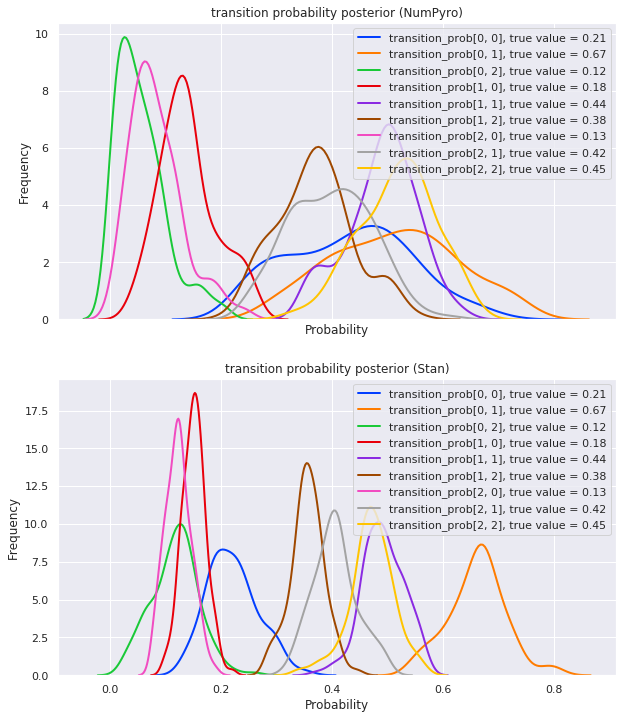

In [19]:
def plot(ax, transition_prob_posterior, title):
    for i in range(num_categories):
        for j in range(num_categories):
            sns.distplot(transition_prob_posterior[:, i, j], hist=False, kde_kws={"lw": 2},
                         label="transition_prob[{}, {}], true value = {:.2f}"
                         .format(i, j, transition_prob[i, j]), ax=ax)
    ax.set(xlabel="Probability", ylabel="Frequency",
           title="transition probability posterior ({})".format(title))

_, (ax1, ax2) = plt.subplots(2, figsize=(10, 12), sharex=True)
plot(ax1, hmc_states["transition_prob"], "NumPyro")
plot(ax2, np.array(fit.extract(pars="theta")["theta"]), "Stan")